In [2]:
%matplotlib inline 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# from pandas_profiling import ProfileReport
import numpy as np

In [3]:
df = pd.read_csv('data/data_Inmeta.csv', sep=';', header=0)
df.head(20)

,Y,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,13500,23,46986,1.0,90,1,0,2000,3,1165
1,13750,23,72937,1.0,90,1,0,2000,3,1165
2,13950,24,41711,1.0,90,1,0,2000,3,1165
3,14950,26,48000,1.0,90,0,0,2000,3,1165
4,13750,30,38500,1.0,90,0,0,2000,3,1170
5,12950,32,61000,1.0,90,0,0,2000,3,1170
6,16900,27,94612,1.0,90,1,0,2000,3,1245
7,18600,30,75889,1.0,90,1,0,2000,3,1245
8,21500,27,19700,0.0,192,0,0,1800,3,1185
9,12950,23,71138,1.0,69,0,0,1900,3,1105


# Exploratory Data Analysis

In [4]:
print(df.describe())
print(df.info())

                  Y    Feature 1      Feature 2   Feature 3    Feature 4  \
count   1436.000000  1436.000000    1436.000000  414.000000  1436.000000   
mean   10730.824513    55.947075   68533.259749    0.173913   101.502089   
std     3626.964585    18.599988   37506.448872    0.379493    14.981080   
min     4350.000000     1.000000       1.000000    0.000000    69.000000   
25%     8450.000000    44.000000   43000.000000    0.000000    90.000000   
50%     9900.000000    61.000000   63389.500000    0.000000   110.000000   
75%    11950.000000    70.000000   87020.750000    0.000000   110.000000   
max    32500.000000    80.000000  243000.000000    1.000000   192.000000   

         Feature 5    Feature 6    Feature 7    Feature 8   Feature 9  
count  1436.000000  1436.000000  1436.000000  1436.000000  1436.00000  
mean      0.674791     0.055710  1566.827994     4.033426  1072.45961  
std       0.468616     0.229441   187.182436     0.952677    52.64112  
min       0.000000     0.00

Binary features: 3, 5, 6, Mising values: 3

<AxesSubplot:>

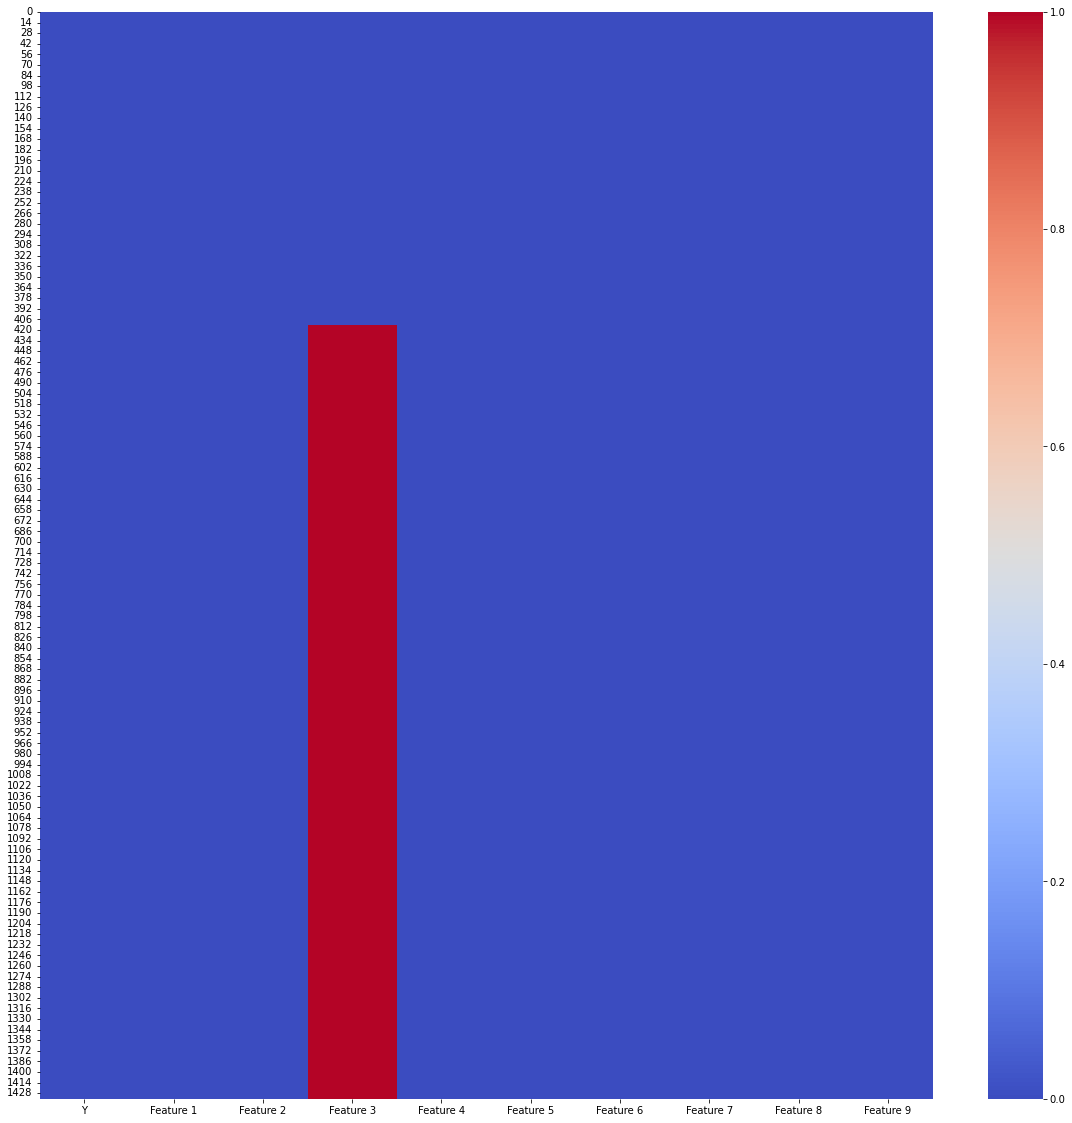

In [5]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.isnull(), cmap='coolwarm', cbar=True)

<AxesSubplot:>

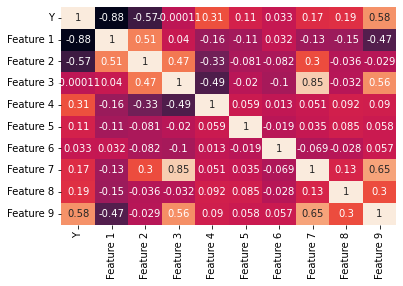

In [6]:
sns.heatmap(df.corr(), annot=True, cbar=False)

In [7]:
# Find the duplications
df[df.duplicated(keep=False)]

,Y,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
112,24950,8,13253,1.0,116,1,0,2000,5,1320
113,24950,8,13253,1.0,116,1,0,2000,5,1320


23915.000000000007
Number of points above extreme line:  8


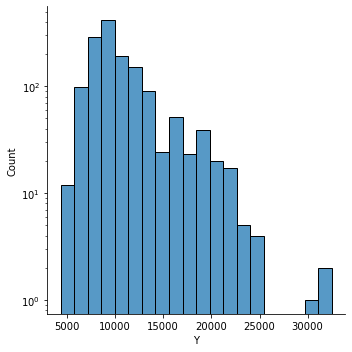

In [8]:
sns.displot(df['Y'], bins=20)
plt.yscale('log')
threshold = np.percentile(df['Y'], q=99.5)
print(threshold)
print('Number of points above extreme line: ', len(df[df['Y'] > threshold]))

In [9]:
# # Pandas profiling
# profile = ProfileReport(df)
# profile

# Data Preprocessing

## Drop missing column and duplicated row

In [10]:
# Drop column feature 3
df_clean = df.drop('Feature 3', axis=1)
# Drop duplicates
df_clean = df_clean.drop_duplicates(keep='first')

In [11]:
# Filter outliers using 99 percentile
# threshold = np.percentile(df_clean['Y'], q=99.9)
# threshold = np.mean(df_clean['Y']) + np.std(df_clean['Y'])
threshold = 26000
print('threshold ', threshold)
df_clean = df_clean[df_clean['Y'] <= threshold]
print('Shape after filter ', df_clean.shape)

threshold  26000
Shape after filter  (1432, 9)


## Seperate X, y

In [12]:
X = df_clean.drop('Y', axis=1)
# X = np.array(df_clean['Feature 1']).reshape(-1, 1)
y = df_clean['Y']

## Scaler

In [13]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
X = scl.fit_transform(X)


In [14]:
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7
count,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000
mean,0.697334,0.282761,0.263915,0.674581,0.055866,0.379454,0.676909,0.116151
std,0.233283,0.153932,0.121808,0.468695,0.229743,0.265765,0.317545,0.079438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.544304,0.176951,0.162602,0.000000,0.000000,0.142857,0.333333,0.065041
50%,0.759494,0.261229,0.333333,1.000000,0.000000,0.428571,0.666667,0.111382
75%,0.873418,0.358560,0.333333,1.000000,0.000000,0.428571,1.000000,0.138211
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## PCA (disabled)

In [15]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=4)
# X = pca.fit_transform(X)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')

## Train test split

In [16]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Utils

In [17]:
#Visualization code

def vis(y_test, y_pred):

    # Distribution on the line
    fig, ax = plt.subplots(3, 1, figsize=(20,20))
    ax[0].scatter(y_pred, y_test, color='red')
    ax[0].set_xlabel('Predictions', fontsize = 15)
    ax[0].set_ylabel('Ground truths', fontsize = 15)
    ax[0].set_title('Predictions x Ground truths on dataset', fontsize = 15)
    ax[0].plot([0, max(y_test)], [0, max(y_test)], 'g--')

    # Scatter overlapping
    x = range(len(y_test))
    ax[1].scatter(x, y_test, color='blue', label='Ground truth', marker='o')
    ax[1].scatter(x, y_pred, color='green', label='Predictions', marker='x')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Scatter plot of ground truth and prediction', fontsize = 15)

    # Residual histogram
    sns.histplot(abs(y_pred - y_test), ax=ax[2], bins=10)
    ax[2].set_title('Residuals distribution', fontsize = 15)
    
    print('RMSE', mean_squared_error(y_test, y_pred, squared=False))
    print('MSE:', mean_squared_error(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('r2_score: ', r2_score(y_test, y_pred))


    plt.show()
    

In [18]:
def read_cv_test_result(cv_dict, cv=5):
    dic = dict()
    for key in cv_dict.keys():
        if key.startswith('test'):
            dic['Average {}-fold '.format(cv)+key] = cv_dict[key].mean()
            # print('Average {}-fold '.format(cv)+key)
            # print(cv_dict[key].mean())
    
    print(pd.DataFrame(cv_dict).head(20))
    return(dic)


# Data modelling

In [19]:
cv_scoring_metrics = ('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_root_mean_squared_error')
folds = KFold(n_splits=5, shuffle=True, random_state=123)

## Linear Regression

RMSE 1280.6577033940157
MSE: 1640084.1532624345
MAE:  940.2947259970583
r2_score:  0.8699589366395352


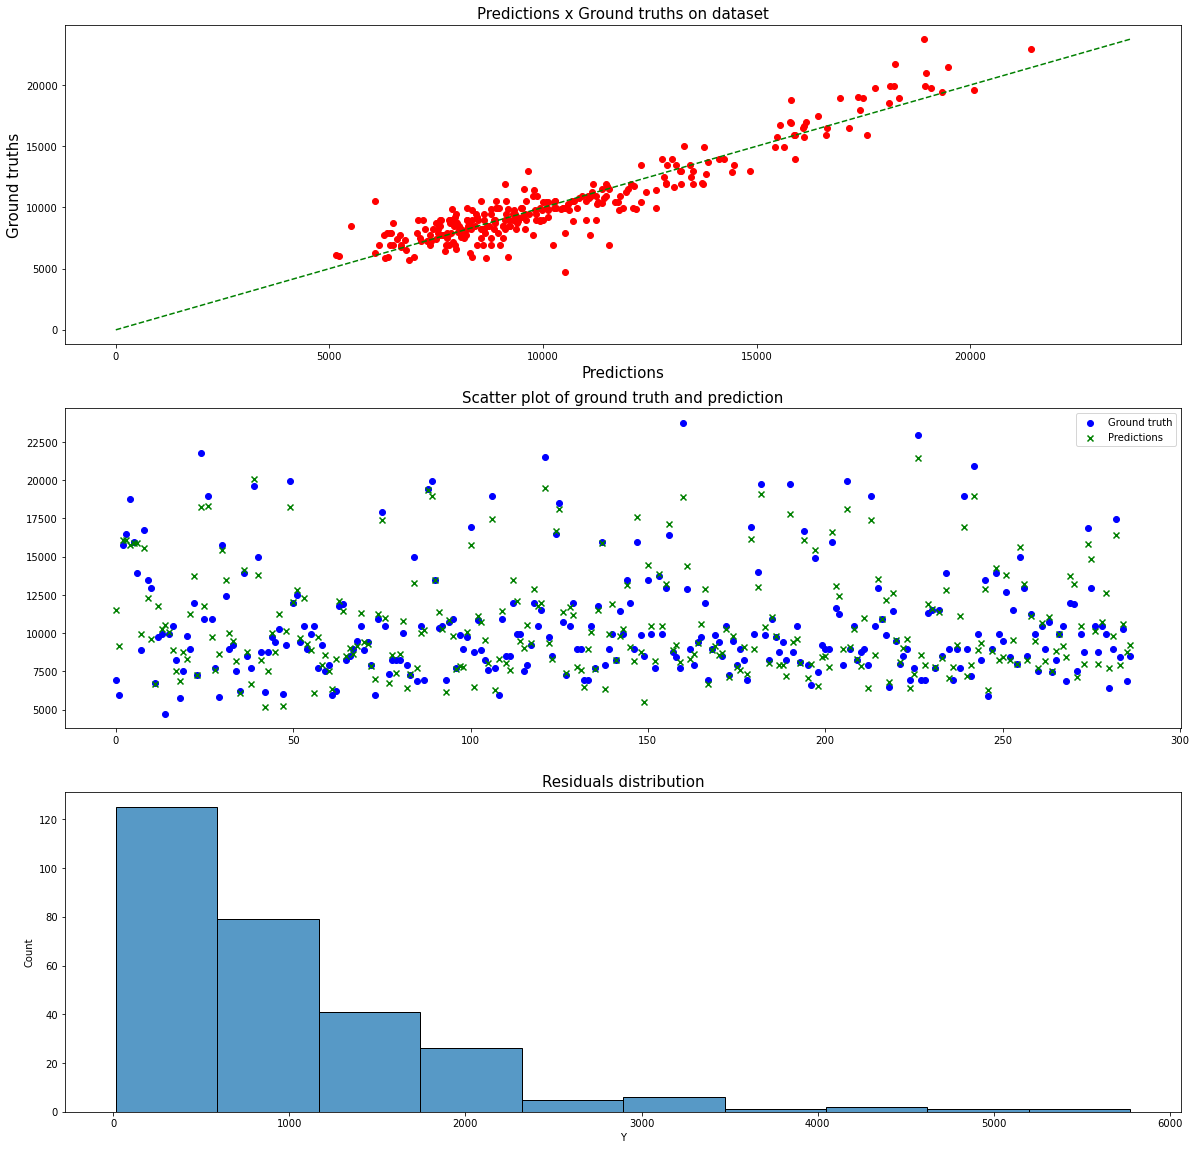

In [20]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
vis(y_test, y_predict)

In [21]:
# Cross validation
lr_cv_scores = cross_validate(lr, X, y, cv=folds, scoring=cv_scoring_metrics)
lr_dict = read_cv_test_result(lr_cv_scores)

   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.001010    0.000608  0.869959                -1.640084e+06   
1  0.002938    0.000797  0.852991                -1.908400e+06   
2  0.001007    0.000565  0.861088                -1.675154e+06   
3  0.000706    0.000640  0.811876                -1.995825e+06   
4  0.001318    0.000554  0.864020                -1.642711e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                   -940.294726                      -1280.657703  
1                  -1019.975013                      -1381.448656  
2                   -947.876844                      -1294.277510  
3                   -956.000980                      -1412.736694  
4                   -996.537086                      -1281.682910  


## Decision Tree

RMSE 1404.6432483204642
MSE: 1973022.655052265
MAE:  1100.2439024390244
r2_score:  0.8435604882914634


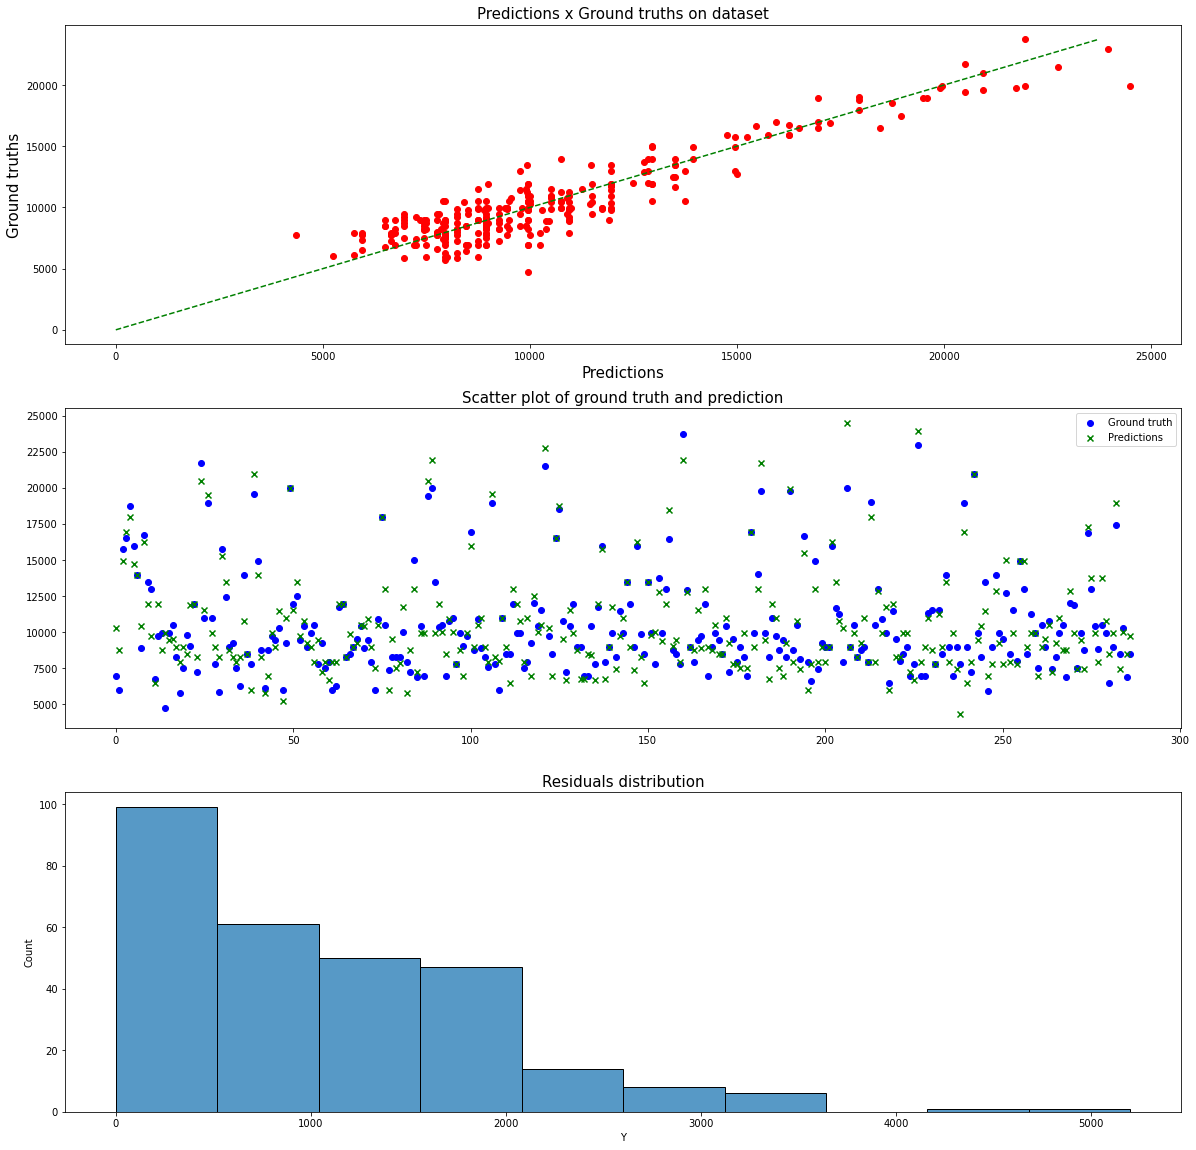

In [22]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
dc = DecisionTreeRegressor()
dc.fit(X_train, y_train)
dc_pred = dc.predict(X_test)
vis(y_test, dc_pred)

In [23]:
dc_cv_scores = cross_validate(dc, X, y, cv=folds, scoring=cv_scoring_metrics)
dc_dict = read_cv_test_result(dc_cv_scores)

   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.003474    0.000754  0.840628                -2.010010e+06   
1  0.003756    0.000908  0.838118                -2.101470e+06   
2  0.003172    0.000718  0.818171                -2.192694e+06   
3  0.003192    0.000907  0.780746                -2.326091e+06   
4  0.003053    0.000563  0.850600                -1.804833e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                  -1104.585366                      -1417.748224  
1                  -1115.794425                      -1449.644920  
2                  -1118.559441                      -1480.774698  
3                  -1141.867133                      -1525.152942  
4                  -1042.286713                      -1343.440813  


## Random Forest

RMSE 1107.5521764123293
MSE: 1226671.8234756873
MAE:  833.156713124274
r2_score:  0.902738095480169


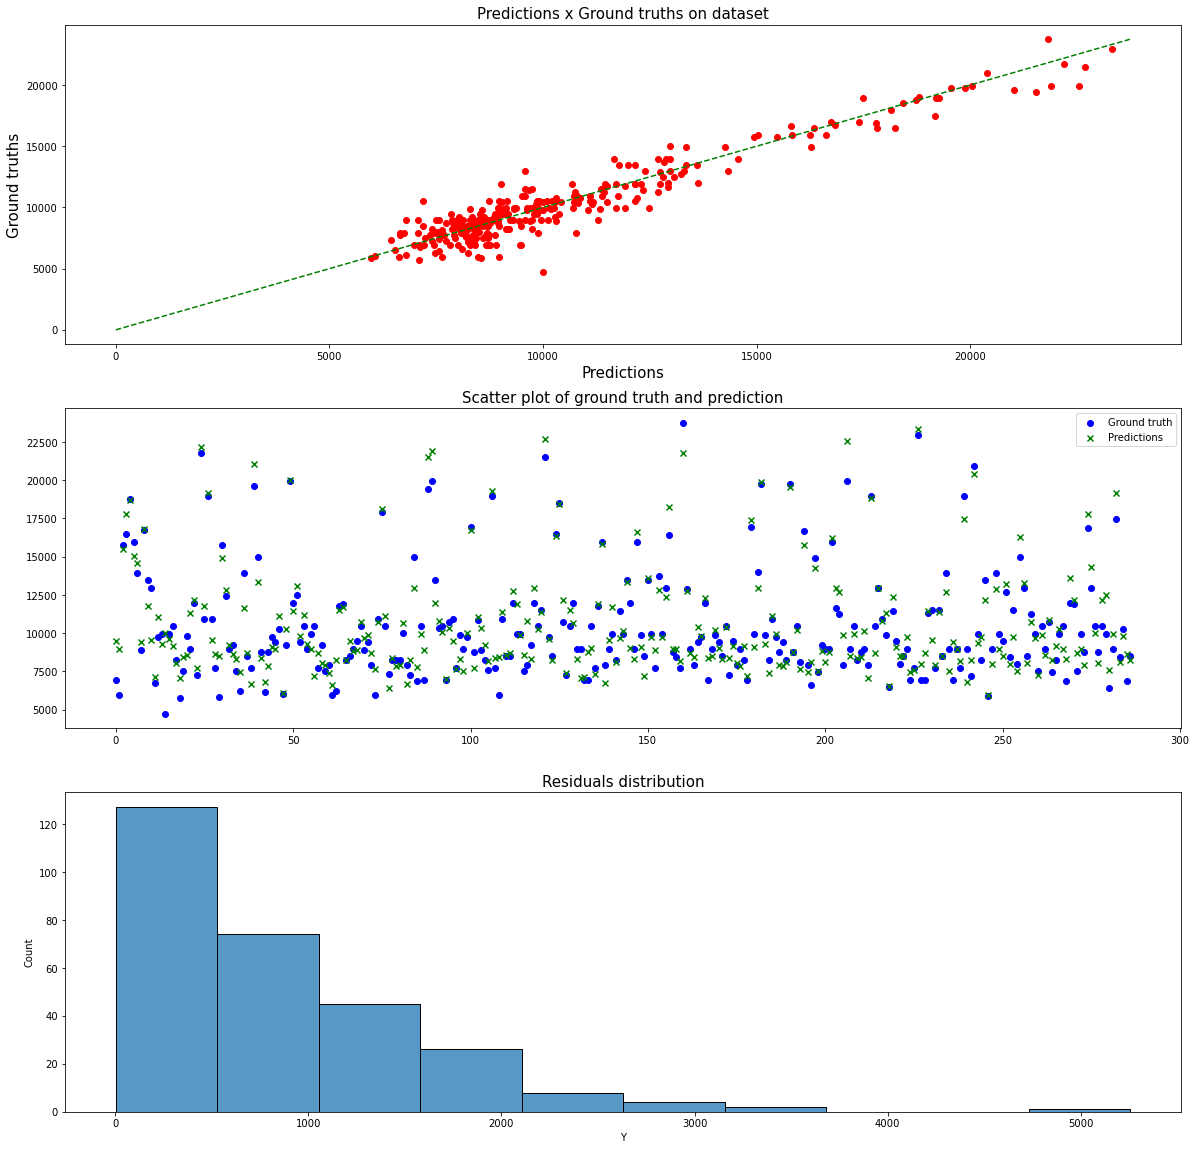

In [24]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)
vis(y_test, rf_predict)

In [25]:
rf_cv_scores = cross_validate(rf, X, y, cv=folds, scoring=cv_scoring_metrics)
rf_dict = read_cv_test_result(rf_cv_scores)

   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.241099    0.007252  0.902212                -1.233308e+06   
1  0.229413    0.007893  0.903516                -1.252508e+06   
2  0.250570    0.007451  0.913291                -1.045632e+06   
3  0.215136    0.007108  0.857472                -1.512091e+06   
4  0.222845    0.007032  0.898231                -1.229423e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                   -839.263182                      -1110.543969  
1                   -867.397003                      -1119.155253  
2                   -774.215210                      -1022.561467  
3                   -896.821748                      -1229.670980  
4                   -830.319930                      -1108.793374  


In [26]:
# feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
# feat_importances.nlargest(20).plot(kind='bar')

## XGBoost

RMSE 1153.6158121204146
MSE: 1330829.4419742436
MAE:  867.1055997522866
r2_score:  0.8944795146996019


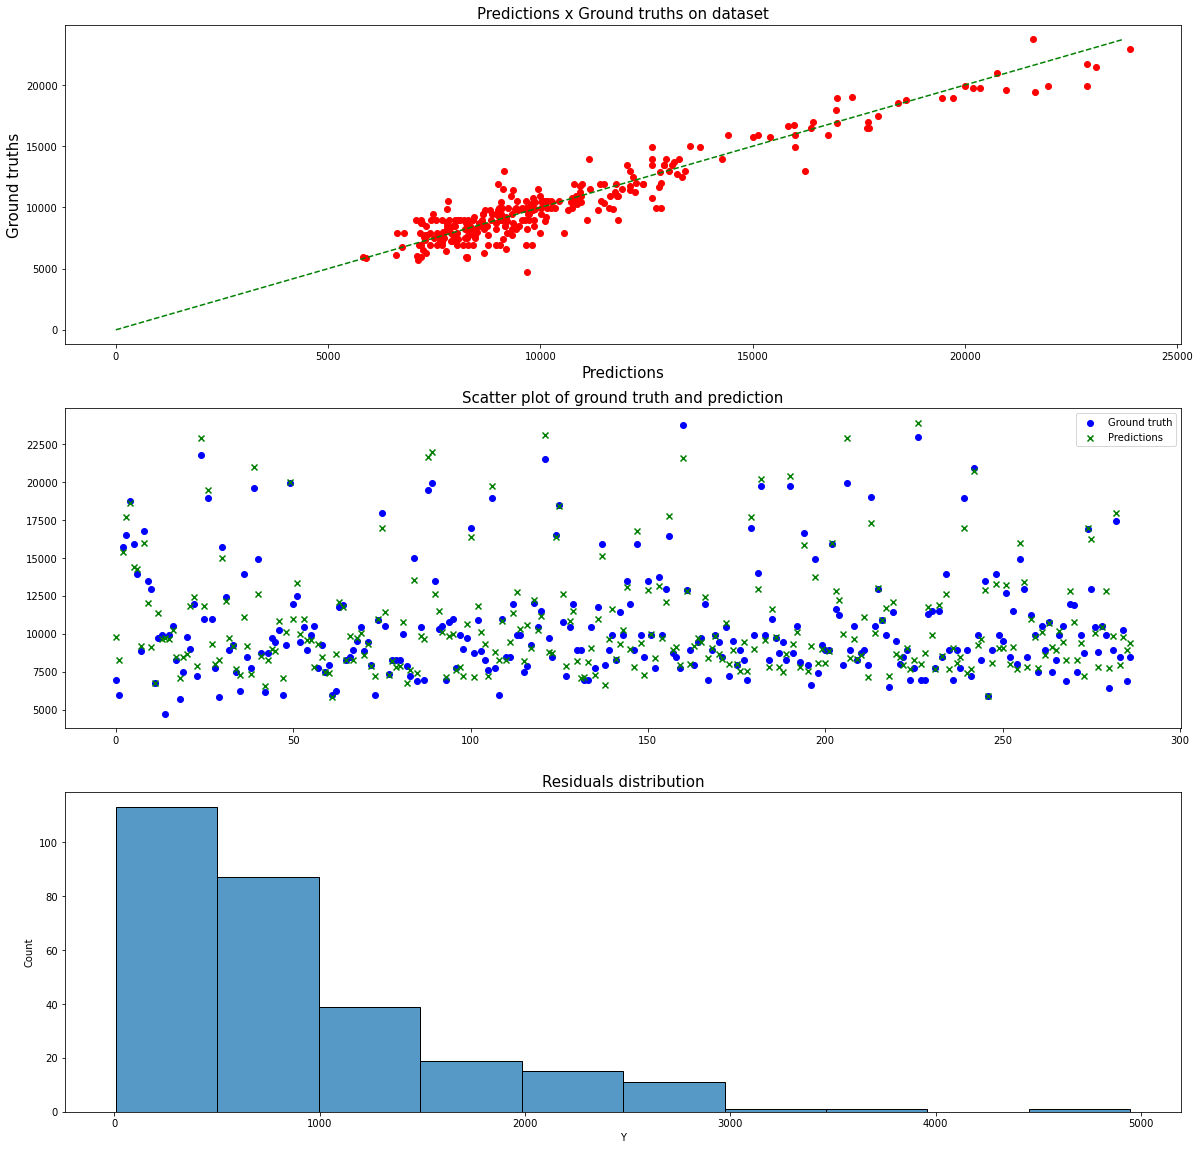

In [27]:
from xgboost import XGBRegressor
xg = XGBRegressor()
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_test)
vis(y_test, xg_pred)

In [28]:
# feat_importances = pd.Series(xg.feature_importances_, index=X.columns)
# feat_importances.nlargest(20).plot(kind='bar')

In [29]:
xg_cv_scores = cross_validate(xg, X, y, cv=folds, scoring=cv_scoring_metrics)
xg_dict = read_cv_test_result(xg_cv_scores)

   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  0.132220    0.002119  0.894480                -1.330829e+06   
1  0.111958    0.003173  0.879277                -1.567164e+06   
2  0.112752    0.002100  0.909088                -1.096319e+06   
3  0.116709    0.002194  0.865655                -1.425278e+06   
4  0.135089    0.003177  0.887041                -1.364609e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                   -867.105600                      -1153.615812  
1                   -944.604065                      -1251.864390  
2                   -823.844313                      -1047.052757  
3                   -919.432484                      -1193.850088  
4                   -882.534922                      -1168.164609  


## ANN

In [30]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential

In [31]:
from tensorflow.keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def build_model(input_shape, depth=3, hidden_nodes=[30, 20, 20, 30], ):
    ann = Sequential()
    ann.add(Input(shape=X_train.shape[1]))

    for i in range(depth):
        if(isinstance(hidden_nodes, list)):
            ann.add(Dense(hidden_nodes[i], activation='relu'))
        elif(isinstance(hidden_nodes, int)):
            ann.add(Dense(hidden_nodes, activation='relu'))

    ann.add(Dense(1, activation='linear'))
    ann.summary()

    ann.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error', 'mse', coeff_determination])
    return ann

2021-11-25 22:05:01.200894: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-25 22:05:01.261747: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
36/36 [==============================] - 0s 636us/step - loss: 10725.1436 - mean_absolute_error: 10725.1436 - mse: 127020744.0000 - coeff_determination: -11.4969
Epoch 2/300
36/36 [==============================] - 0s 565us/step - loss: 107

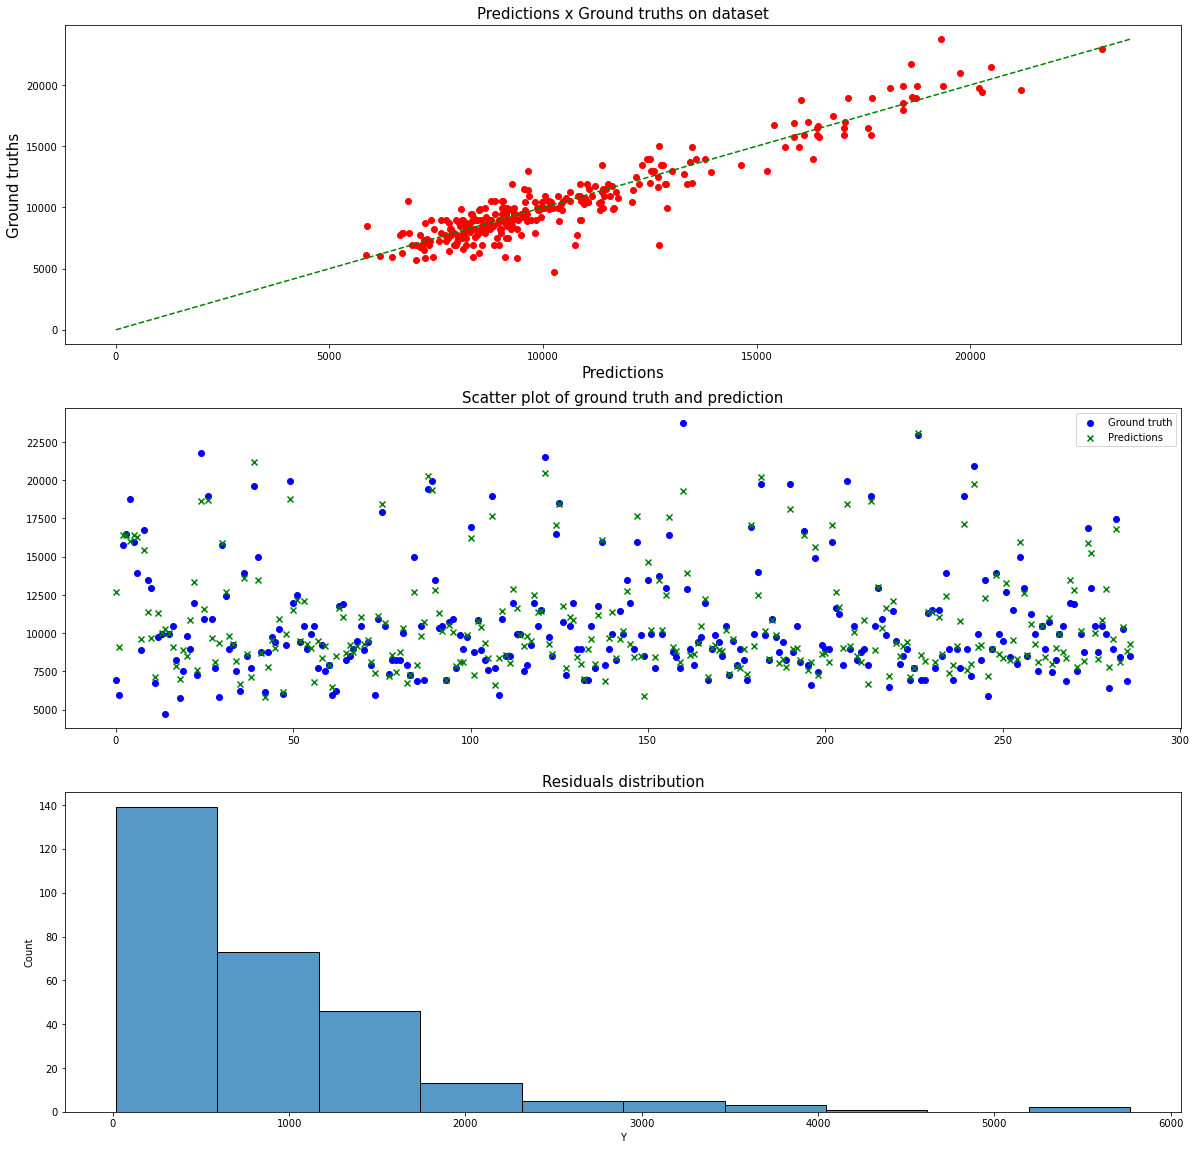

In [32]:
ann = build_model(input_shape=X_train.shape[1])
ann.fit(X_train, y_train, epochs=300)
ann_pred = ann.predict(X_test)
vis(y_test, ann_pred.reshape(-1))

In [33]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
estimator = KerasRegressor(build_fn = lambda: build_model(X.shape[1]), epochs=300, verbose=False)
ann_cv_results = cross_validate(estimator, X, y, cv=folds, scoring=cv_scoring_metrics)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                270       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_6 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 30)                270       
______________________________

In [34]:
ann_dict = read_cv_test_result(ann_cv_results)

   fit_time  score_time   test_r2  test_neg_mean_squared_error  \
0  5.299379    0.045707  0.890674                -1.378820e+06   
1  5.485287    0.040841  0.874522                -1.628895e+06   
2  5.380542    0.043208  0.864865                -1.629602e+06   
3  5.287756    0.040708  0.809183                -2.024394e+06   
4  5.344027    0.042173  0.888371                -1.348541e+06   

   test_neg_mean_absolute_error  test_neg_root_mean_squared_error  
0                   -848.469293                      -1174.231549  
1                   -925.559834                      -1276.281615  
2                   -880.327790                      -1276.558644  
3                   -890.287586                      -1422.812124  
4                   -870.637446                      -1161.266792  


# Conclusion

In [36]:
conclusion_df = pd.DataFrame([lr_dict, dc_dict, rf_dict, xg_dict, ann_dict])
conclusion_df['Model name'] = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'ANN']
conclusion_df.set_index('Model name', inplace=True)
conclusion_df.to_csv('Minmax_scaling.csv')
conclusion_df.head(10)


,Average 5-fold test_r2,Average 5-fold test_neg_mean_squared_error,Average 5-fold test_neg_mean_absolute_error,Average 5-fold test_neg_root_mean_squared_error
Model name,,,,
Linear Regression,0.851987,-1.772435e+06,-972.136930,-1330.160695
Decision Tree,0.825652,-2.087020e+06,-1104.618616,-1443.352319
Random Forest,0.894944,-1.254592e+06,-841.603415,-1118.145009
XGBoost,0.887108,-1.356840e+06,-887.504277,-1162.909531
ANN,0.865523,-1.602050e+06,-883.056390,-1262.230145


Tree Esemble methods perform best on this problem
--> Lesson learn: apply dropout to ANN